# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [42]:
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

import json

from collections import OrderedDict

import time

import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [11]:
data_dir = 'flowers'
print(data_dir)
train_dir = data_dir + '/train'
print(train_dir)
valid_dir = data_dir + '/valid'
print(valid_dir)
test_dir = data_dir + '/test'
print(test_dir)

flowers
flowers/train
flowers/valid
flowers/test


In [12]:
# defines transforms for the training, validation, and testing sets

# training transform
# random rotation and flip build a more robust model
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# validation set
# uses the same transform as the test set
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

# test set
# uses the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]) 

# loads the datasets using ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
print(train_data)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
print(test_data)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms) # cost
print(valid_data) # cost

# defines the dataloader using the image datasets and the transforms
# uses shuffle=True so the order of the images does not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

# defines image datasets and dataloaders
image_datasets = [train_data, valid_data, test_data]
dataloaders = [trainloader, validloader, testloader]

Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 819
    Root Location: flowers/test
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
# loads in mapping from category label to category name
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

    # prints json file
    print(cat_to_name)

no_output_categories = len(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [14]:
# builds the network

# defines number of hidden units
hidden_units = 4096

# uses vgg16 because vgg11 performed poorly
# progress substites 'pretrained', which has been deprecated
model = models.vgg16_bn(pretrained=True)

# the weights of the pretrained model are frozen to avoid backpropping through them
for param in model.parameters():
    param.requires_grad = False

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [15]:
# defines the classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, hidden_units)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.05)),
                          ('fc2', nn.Linear(hidden_units, no_output_categories)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replaces the pretrained classifier with the one created above
model.classifier = classifier

model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.05)
  (fc2): Linear(in_features=4096, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [16]:
# trains the model

# sets device to either cuda or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'The device in use is {device}.\n')

# sets the training hyperparameters
epochs = 10 # should be OK to avoid overfitting
optimizer = optim.Adam(model.classifier.parameters(),lr=.001) # makes use of momentum to avoid local minima
criterion = nn.NLLLoss() # recommended when using Softmax

print_every = 20 # the model trains on 20 batches of images at a time

running_loss = running_accuracy = 0
validation_losses, training_losses = [],[]


# defines the training process
for e in range(epochs):
    batches = 0 # 1 batch = 64 images

    # turns on training mode
    model.train()

    for images,labels in trainloader:
        start = time.time() # defines start time
        batches += 1

        # moves images and labels to the GPU
        images,labels = images.to(device),labels.to(device)

        # pushes batch through network
        log_ps = model.forward(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()

        # calculates the metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1,dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        accuracy = matches.mean()

        # resets optimiser gradient and tracks metrics
        optimizer.zero_grad()
        running_loss += loss.item()
        running_accuracy += accuracy.item()

        # runs the model on the validation set every 5 loops
        if batches%print_every == 0:
            end = time.time()
            training_time = end-start
            start = time.time()

            # sets the metrics
            validation_loss = 0
            validation_accuracy = 0

            # turns on evaluation mode, turns off calculation of gradients
            model.eval()
            with torch.no_grad():
                for images,labels in validloader:
                    images,labels = images.to(device),labels.to(device)
                    log_ps = model.forward(images)
                    loss = criterion(log_ps,labels)
                    ps = torch.exp(log_ps)
                    top_ps, top_class = ps.topk(1,dim=1)
                    matches = (top_class == \
                                labels.view(*top_class.shape)).type(torch.FloatTensor)
                    accuracy = matches.mean()

                    # tracks validation metrics (test of the model's progress)
                    validation_loss += loss.item()
                    validation_accuracy += accuracy.item()
                
            # tracks training metrics
            end = time.time()
            validation_time = end-start
            validation_losses.append(running_loss/print_every)
            training_losses.append(validation_loss/len(validloader))
                
            # prints out metrics
            print(f'Epoch {e+1}/{epochs} | Batch {batches}')
            print(f'Running Training Loss: {running_loss/print_every:.3f}')
            print(f'Running Training Accuracy: {running_accuracy/print_every*100:.2f}%')
            print(f'Validation Loss: {validation_loss/len(validloader):.3f}')
            print(f'Validation Accuracy: {validation_accuracy/len(validloader)*100:.2f}%')

            # resets the metrics and turns on training mode
            running_loss = running_accuracy = 0
            model.train()

The device in use is cuda:0.

Epoch 1/10 | Batch 20
Running Training Loss: 4.932
Running Training Accuracy: 13.75%
Validation Loss: 3.095
Validation Accuracy: 36.91%
Epoch 1/10 | Batch 40
Running Training Loss: 2.736
Running Training Accuracy: 40.47%
Validation Loss: 1.807
Validation Accuracy: 56.69%
Epoch 1/10 | Batch 60
Running Training Loss: 1.820
Running Training Accuracy: 55.78%
Validation Loss: 1.009
Validation Accuracy: 71.77%
Epoch 1/10 | Batch 80
Running Training Loss: 1.387
Running Training Accuracy: 65.16%
Validation Loss: 0.757
Validation Accuracy: 79.69%
Epoch 1/10 | Batch 100
Running Training Loss: 1.179
Running Training Accuracy: 70.23%
Validation Loss: 0.674
Validation Accuracy: 80.28%
Epoch 2/10 | Batch 20
Running Training Loss: 1.187
Running Training Accuracy: 82.81%
Validation Loss: 0.517
Validation Accuracy: 85.60%
Epoch 2/10 | Batch 40
Running Training Loss: 0.930
Running Training Accuracy: 74.92%
Validation Loss: 0.505
Validation Accuracy: 86.83%
Epoch 2/10 | Batc

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [18]:
# does validation on the test set

# defines test accuracy
test_accuracy = 0

# defines start time
start_time = time.time()
print('Validation started.')

# defines tests
for images,labels in testloader:
    model.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy

# defines end time
end_time = time.time()
print('Validation ended.')
validation_time = end_time - start_time
print('Validation time: {:.0f}m {:.0f}s'.format(validation_time / 60, validation_time % 60))
    
# prints metrics
print(f'Test Accuracy: {test_accuracy/len(testloader)*100:.2f}%')

Validation started.
Validation ended.
Validation time: 0m 20s
Test Accuracy: 90.93%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# saves the checkpoint 

# saves the checkpoint in the current directory
destination_directory = None
class_to_idx = train_data.class_to_idx # improves label to name mapping

# saves the model's state_dict
def save_model(trained_model,hidden_units,output_units,destination_directory,model_arch,class_to_idx):
    # defines model's checkpoint
    model_checkpoint = {'model_arch':model_arch, 
                    'clf_input':25088,
                    'clf_output':output_units,
                    'clf_hidden':hidden_units,
                    'state_dict':trained_model.state_dict(),
                    'model_class_to_index':class_to_idx,
                    }
    
    # saves model in current directory
    if destination_directory:
        torch.save(model_checkpoint,destination_directory+"/"+model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to {destination_directory}")
    else:
        torch.save(model_checkpoint,model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to current directory as {model_arch}_checkpoint.pth")

# calls save_model
save_model(model,hidden_units,no_output_categories,destination_directory,'vgg16_bn',class_to_idx)

vgg16_bn successfully saved to current directory as vgg16_bn_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [36]:
# writes a function that loads a checkpoint and rebuilds the model

# defines checkpoint as file created above
checkpoint = 'vgg16_bn_checkpoint.pth'

# function that accepts two arguments: filepath (location of checkpoint) and device(gpu/cpu)
def load_checkpoint(filepath,device):
    # loads the GPU when available
    if device=="gpu":
        map_location=lambda device, loc: device.cuda()
    else:
        map_location='cpu'
        
    # redefines checkpoint
    checkpoint = torch.load(f=filepath,map_location=map_location)

    # function returns number of input units, output units, hidden units, and state_dict
    return checkpoint['model_arch'],checkpoint['clf_input'], checkpoint['clf_output'], checkpoint['clf_hidden'],checkpoint['state_dict'],checkpoint['model_class_to_index']

# loads the checkpoint
model_arch,input_units, output_units, hidden_units, state_dict, class_to_idx = load_checkpoint(checkpoint,device)
model.load_state_dict(state_dict)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [62]:
# defines the location of the images to preprocess
practice_img = './flowers/test/19/image_06186.jpg'
# practice_img2 = './flowers/test/70/image_05331.jpg'
# practice_img3 = './flowers/test/100/image_07926.jpg'

# processes a PIL image for use in a PyTorch model
# returns results as numpy array
def process_image(image):
    processed_image = Image.open(image).convert('RGB') # open the image
    # resizes image
    processed_image.thumbnail(size=(256,256)) # keeps aspect ratio
    width, height = processed_image.size # gets image dimensions

    # sets new dimensions for center crop
    new_width,new_height = 224,224 
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    processed_image = processed_image.crop((left, top, right, bottom))

    # converts to tensor adn normalises
    transf_tens = transforms.ToTensor()
    transf_norm = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    tensor = transf_norm(transf_tens(processed_image))
    
    # convert tensor result to numpy array
    np_processed_image = np.array(tensor)
    return np_processed_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [63]:
# utilises imshow for tensor
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        plt.tick_params(
            axis='both',          
            which='both',     
            bottom=False,      
            top=False,
            left=False,         
            labelbottom=False,
            labelleft=False,)
        
    # We need to move the color channel from the first dimension to the third dimension.
    # PyTorch expects color to be in the 1st dim, but PIL expects it to be in the 3rd!
    image = image.transpose((1, 2, 0))
    
    # undoes preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # image needs to be clipped between 0 and 1
    # otherwise it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

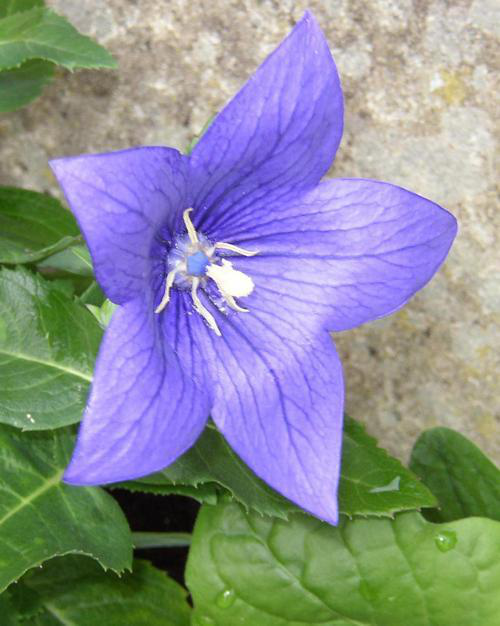

In [64]:
from PIL import Image

# displays original image
processed_image = Image.open(practice_img)
processed_image

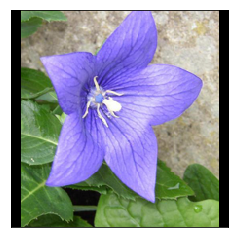

In [65]:
# displays preprocessed image
imshow(process_image(practice_img))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [66]:
# implements the code to predict the class from an image file

file = 'cat_to_name.json'

# takes .json file and converts it into a dictionary
def class_to_label(file,classes):
    with open(file, 'r') as f:
        class_mapping =  json.load(f)
        
    labels = []
    for c in classes:
        labels.append(class_mapping[c])
    return labels

# usies class_to_label() to map folder labels (1-102) to flower names
idx_mapping = dict(map(reversed, class_to_idx.items()))

# predicts the class of an image using out deep learning model
# mapping is the dictionary mapping indices to classes
def predict(image_path, model,idx_mapping, topk, device):
    # defines preprocessed image
    pre_processed_image = torch.from_numpy(process_image(image_path))
    pre_processed_image = torch.unsqueeze(pre_processed_image,0).to(device).float()
    
    model.to(device)
    model.eval()
    
    log_ps = model.forward(pre_processed_image)
    ps = torch.exp(log_ps)
    top_ps,top_idx = ps.topk(topk,dim=1)
    list_ps = top_ps.tolist()[0]
    list_idx = top_idx.tolist()[0]
    classes = []
    model.train()
    
    for x in list_idx:
        classes.append(idx_mapping[x])
    return list_ps, classes

# prints the probability output
def print_predictions(probabilities, classes,image,category_names=None):
    # prints out the image
    print(image)
    
    if category_names:
        labels = class_to_label(category_names,classes)
        for i,(ps,ls,cs) in enumerate(zip(probabilities,labels,classes),1):
            print(f'{i}) {ps*100:.2f}% {ls.title()} | Class No. {cs}')
    else:
        for i,(ps,cs) in enumerate(zip(probabilities,classes),1):
            print(f'{i}) {ps*100:.2f}% Class No. {cs} ')
    print('') 

probabilities,classes = predict(practice_img,model,idx_mapping,5,device)

# prints out the predictions
print_predictions(probabilities,classes,practice_img.split('/')[-1],file)

image_06186.jpg
1) 100.00% Balloon Flower | Class No. 19
2) 0.00% Petunia | Class No. 51
3) 0.00% Pink Primrose | Class No. 1
4) 0.00% Wild Pansy | Class No. 52
5) 0.00% Bougainvillea | Class No. 95



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

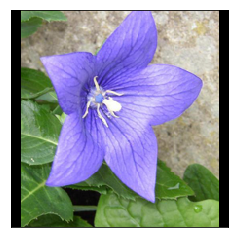

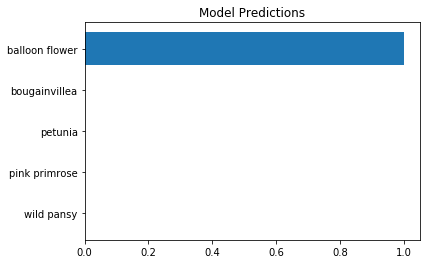

In [67]:
# displays an image along with the top 5 classes
imshow(process_image(practice_img))

# uses matplotlib for the task
plt.figure() # image
# defines probability axis
plt.barh(class_to_label(file,classes),width=probabilities)
plt.title('Model Predictions') # defines title
plt.gca().invert_yaxis() # defines y axis
plt.show() # shows diagram